In [10]:
%load_ext autoreload
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload
from pipeline import Pipeline, BuilingIdsEnum
from utils import plot_energy_usage, ColumnParam
pipe = Pipeline()

In [12]:
daily_a = pipe.get_daily_consumption(BuilingIdsEnum.A)
# select juli 2024
daily_a_selected = daily_a[(daily_a['timestamp'] >= '2024-01-01') & (daily_a['timestamp'] < '2024-08-01')]
plot_cols =[
    ColumnParam("value_import", "Energy Import"),
]
plot_energy_usage(daily_a_selected, plot_cols,
                  titel="Daily Energy Usage A Building",
                  yaxis_title="Energy [kWh]",
                  tozeroy=False,
                  )

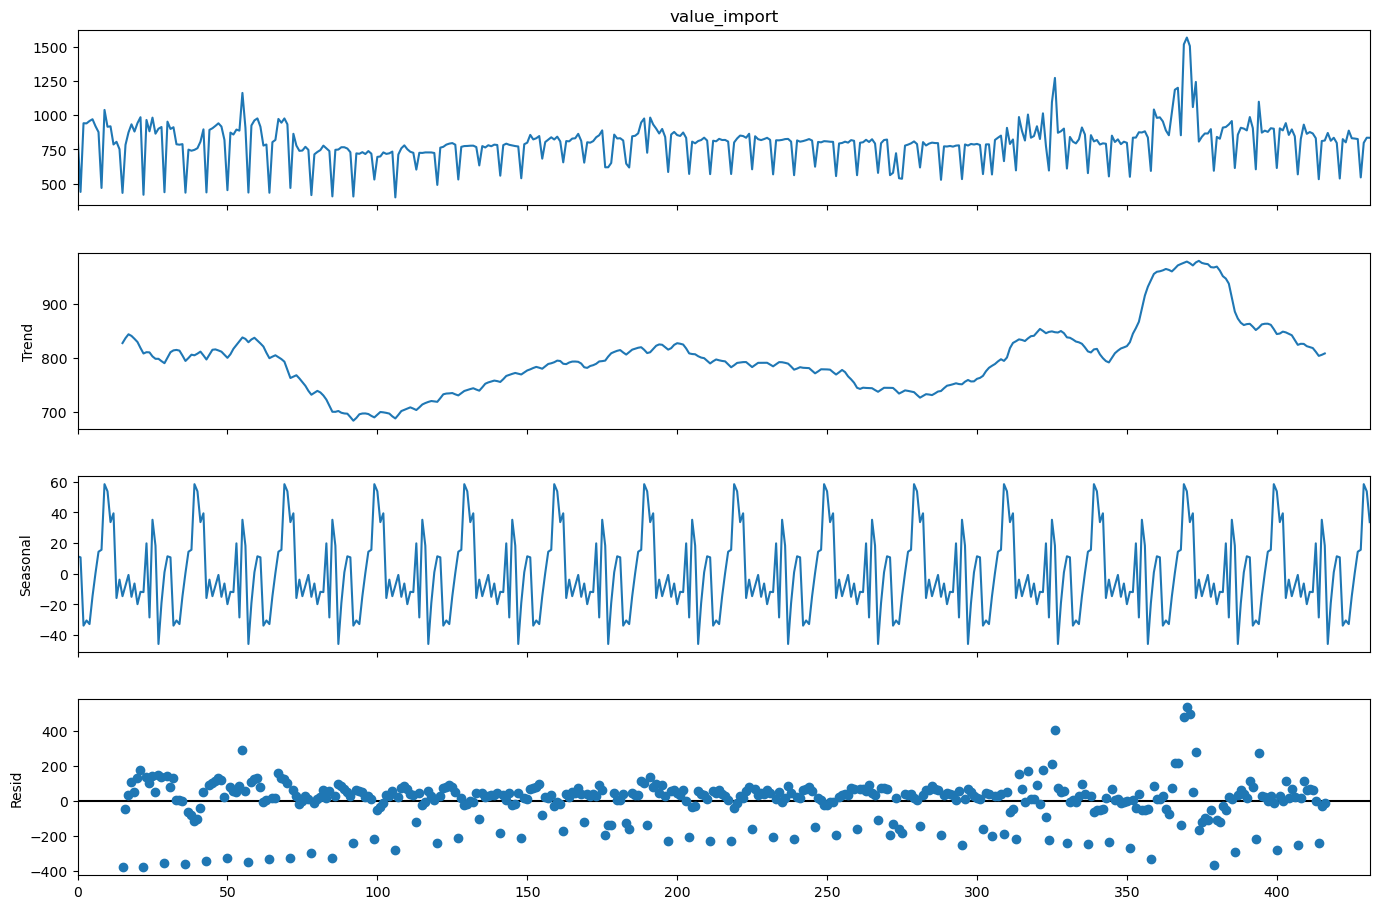

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(daily_a['value_import'], model='additive', period=30)  # Assuming monthly seasonality

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()


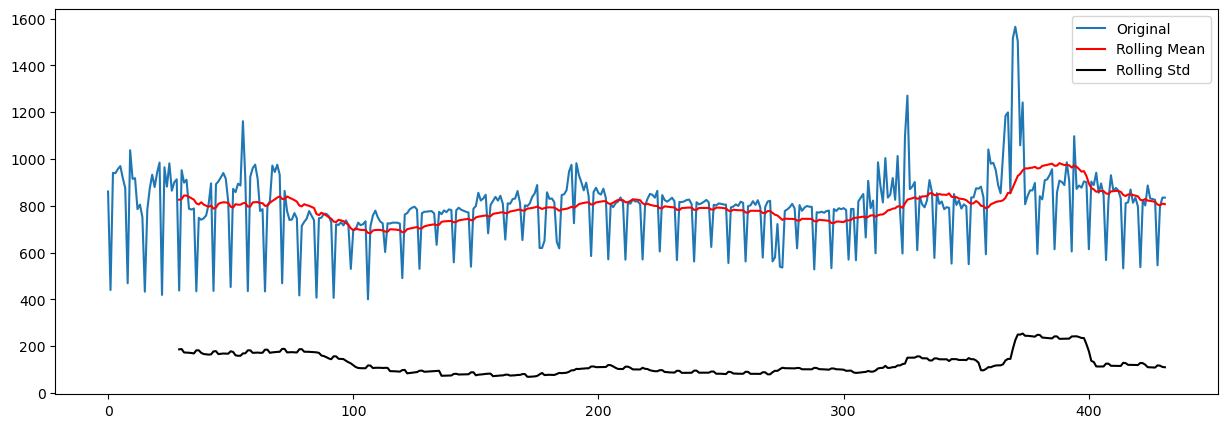

In [14]:
rolling_mean = daily_a['value_import'].rolling(window=30).mean()
rolling_std = daily_a['value_import'].rolling(window=30).std()

plt.figure(figsize=(15,5))
plt.plot(daily_a['value_import'], label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend()
plt.show()


In [15]:
import numpy as np
from scipy import stats

# Calculate Z-scores
daily_a['z_score'] = np.abs(stats.zscore(daily_a['value_import']))

# Define a threshold, e.g., z-score > 3
threshold = 3
daily_a['anomaly_z'] = daily_a['z_score'] > threshold

# Number of anomalies
print(f"Number of anomalies detected by Z-Score: {daily_a['anomaly_z'].sum()}")

# show anonomalies
anonomalies_df = daily_a[daily_a['anomaly_z']]
anonomalies_df



Number of anomalies detected by Z-Score: 5


,timestamp,value_import,net_consumption,net_consumption_per_sqm,building,property_id,area,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,z_score,anomaly_z
326,2024-05-22,1271.2,1271.2,1.089289,building A,10703,1167,17.604167,2.458333,278.8,0.391667,0.000000,3.247965,True
369,2024-07-04,1515.8,1515.8,1.298886,building A,10703,1167,12.295833,2.166667,189.4,0.762500,0.341667,4.931505,True
370,2024-07-05,1565.4,1565.4,1.341388,building A,10703,1167,11.483333,1.166667,104.0,0.612500,0.000000,5.272894,True
371,2024-07-06,1503.8,1503.8,1.288603,building A,10703,1167,12.575000,1.387500,302.9,0.783333,0.150000,4.848911,True
373,2024-07-08,1242.0,1242.0,1.064267,building A,10703,1167,15.079167,1.545833,152.7,0.279167,0.000000,3.046986,True


In [16]:
Q1 = daily_a['value_import'].quantile(0.25)
Q3 = daily_a['value_import'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify anomalies
daily_a['anomaly_iqr'] = (daily_a['value_import'] < lower_bound) | (daily_a['value_import'] > upper_bound)

# Number of anomalies
print(f"Number of anomalies detected by IQR: {daily_a['anomaly_iqr'].sum()}")

anonomalies_df_iqr = daily_a[daily_a['anomaly_iqr']]

anonomalies_df_iqr 

Number of anomalies detected by IQR: 65


,timestamp,value_import,net_consumption,net_consumption_per_sqm,building,property_id,area,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,z_score,anomaly_z,anomaly_iqr
1,2023-07-02,440.20,440.20,0.377207,building A,10703,1167,17.237500,1.654167,320.000000,0.525000,0.033333,2.471667,False,True
8,2023-07-09,469.20,469.20,0.402057,building A,10703,1167,21.800000,1.558333,294.400000,0.320833,0.000000,2.272065,False,True
9,2023-07-10,1037.80,1037.80,0.889289,building A,10703,1167,15.654167,0.804167,20.300000,0.958333,0.283333,1.641513,False,True
15,2023-07-16,433.00,433.00,0.371037,building A,10703,1167,16.483333,2.891667,90.400000,0.895833,0.225000,2.521223,False,True
22,2023-07-23,419.40,419.40,0.359383,building A,10703,1167,15.237500,1.329167,292.700000,0.520833,0.000000,2.614829,False,True
29,2023-07-30,438.00,438.00,0.375321,building A,10703,1167,17.883333,1.741667,124.000000,0.583333,0.012500,2.486809,False,True
36,2023-08-06,434.80,434.80,0.372579,building A,10703,1167,15.954167,1.241667,270.200000,0.891667,0.000000,2.508834,False,True
43,2023-08-13,436.60,436.60,0.374122,building A,10703,1167,16.908333,1.445833,288.300000,0.754167,0.008333,2.496445,False,True
50,2023-08-20,453.00,453.00,0.388175,building A,10703,1167,18.400000,0.983333,318.200000,0.779167,0.158333,2.383566,False,True
55,2023-08-25,1161.80,1161.80,0.995544,building A,10703,1167,13.233333,1.095833,311.800000,0.979167,0.150000,2.494983,False,True


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
# from pyod.models.lgbm import LGBMOD

# Load data
daily_main = pipe.get_daily_consumption(BuilingIdsEnum.A)
daily_main['timestamp'] = pd.to_datetime(daily_main['timestamp'])
daily_main.set_index('timestamp', inplace=True)

# Handle missing values
daily_main.fillna(method='ffill', inplace=True)

# Z-Score
daily_main['z_score'] = np.abs(stats.zscore(daily_main['value_import']))
daily_main['anomaly_z'] = daily_main['z_score'] > 3

# IQR
Q1 = daily_main['value_import'].quantile(0.25)
Q3 = daily_main['value_import'].quantile(0.75)
IQR = Q3 - Q1
daily_main['anomaly_iqr'] = (daily_main['value_import'] < (Q1 - 1.5 * IQR)) | (daily_main['value_import'] > (Q3 + 1.5 * IQR))

# Isolation Forest
X = daily_main[['value_import']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_scaled)
daily_main['anomaly_iforest'] = iso_forest.predict(X_scaled) == -1

# AutoEncoder
auto_encoder = AutoEncoder(hidden_neurons=[64, 32, 16, 32, 64],
                           epochs=100,
                           batch_size=32,
                           contamination=0.01,
                           verbose=0)
auto_encoder.fit(X_scaled)
daily_main['anomaly_autoencoder'] = auto_encoder.predict(X_scaled)

# KNN and LGBM
knn_detector = KNN(contamination=0.01)
lgbm_detector = LGBMOD(contamination=0.01)
knn_detector.fit(X_scaled)
lgbm_detector.fit(X_scaled)
daily_main['anomaly_knn'] = knn_detector.predict(X_scaled) == 1
daily_main['anomaly_lgbm'] = lgbm_detector.predict(X_scaled) == 1

# Combined Anomalies
daily_main['anomaly_combined'] = (
    daily_main['anomaly_z'].astype(int) +
    daily_main['anomaly_iqr'].astype(int) +
    daily_main['anomaly_iforest'].astype(int) +
    daily_main['anomaly_autoencoder'].astype(int) +
    daily_main['anomaly_knn'].astype(int) +
    daily_main['anomaly_lgbm'].astype(int)
) >= 2

# Plot Combined Anomalies
plt.figure(figsize=(15,5))
plt.plot(daily_main.index, daily_main['value_import'], label='Value Import')
plt.scatter(daily_main.index[daily_main['anomaly_combined']], daily_main['value_import'][daily_main['anomaly_combined']],
            color='red', label='Combined Anomalies', marker='x')
plt.title('Combined Anomaly Detection in Value Import for Building A')
plt.xlabel('Date')
plt.ylabel('Value Import')
plt.legend()
plt.show()



/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_32395/2471551975.py:18: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



TypeError: AutoEncoder.__init__() got an unexpected keyword argument 'hidden_neurons'